# Attention seq2seq - Pytorch

Dataset: http://svn.code.sf.net/p/cmusphinx/code/trunk/cmudict/cmudict-0.7b <br>
The goal of this notebook is to implement a seq2seq attention model and a regular seq2seq is implemented alongside to gain a more complete picture. 

## Motivating Attention

The dataset used in this notebook contains mapping of words in English and their pronounciations as a set of phoneme word pairs like so <br>
<small><p style="margin-left: 40px">S-AE1-N-AH0-T-IY0   sanity</p></small>
The task is to use a seq2seq model to learn this mapping so that given a set of phonemes, the model outputs the correct word. It can be seen as emulating spelling bee. Given below is an image of the results obtained from a regular seq2seq model
<img src="seq2seq.png">
The words inside the red square shows a common problem with seq2seq- If only the context vector, i.e., the last hidden state in the encoder network is passed betweeen the encoder and decoder, that single vector carries the burden of encoding the entire sentence, extending upto the last timestep of the decoder. 

Attention allows the decoder network to "focus" on a different part of the encoder's outputs for every time step of the decoder's own outputs.

In [178]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import re
import time, math
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook

import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim

Path = 'data/'

In [179]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Preprocessing

In [180]:
#Get each word that begins with A-Z from each line into a list 
lines = [l.strip().split("  ") for l in open(Path+'cmudict-0.7b', encoding='latin1') 
         if re.match('^[A-Z]', l)]
#Split words and phonemes
lines = [(w, ps.split()) for w, ps in lines]
lines[0]

('A', ['AH0'])

In [181]:
#Get a list of all the unique phonemes from lines and adding _ to position 0 because it corresponds to padding
#when tokenised
phonemes = ["_"]+sorted(set(p for w, ps in lines for p in ps))
len(phonemes)

70

In [182]:
#Map phonemes to indices and letters to indices.
p2i = dict((v, k) for k, v in enumerate(phonemes))
letters = "_abcdefghijklmnopqrstuvwxyz*"
l2i = dict((v, k) for k, v in enumerate(letters))

In [183]:
#Start of sentence token
SOS_token = 0

In [184]:
maxlen = 15
#Map words to corresponding list of phoneme indices. Constraint
pronounce_dict = {w.lower(): [p2i[p] for p in ps] for w, ps in lines
                    if (5<=len(w)<=maxlen) and re.match("^[A-Z]+$", w)}
len(pronounce_dict)

108006

In [185]:
maxlen_p = max([len(v) for k,v in pronounce_dict.items()]); maxlen_p

16

In [186]:
#words contain the number of words in the filtered dictionary
words = np.random.permutation(list(pronounce_dict.keys()))
n = len(words)

#Initialise the input and labels array with zeros so that everywhere except 
#the position of values is padded
input_ = np.zeros((n, maxlen_p), np.int32)
labels_ = np.zeros((n, maxlen), np.int32)

#Fill in the non zero indices
for i, k in enumerate(words):
    for j, p in enumerate(pronounce_dict[k]): input_[i][j]=p
    for j, p in enumerate(k): labels_[i][j] = l2i[p]
        

In [187]:
#Create train, validation sets
(input_train, input_test, labels_train, labels_test, 
    ) = train_test_split(input_, labels_, test_size=0.1)

In [188]:
input_vocab_size, output_vocab_size = len(phonemes), len(letters);input_vocab_size, output_vocab_size

(70, 28)

In [189]:
dim = 240
batch_size = 128

In [190]:
def get_batch(x, y, batch_size=128):
    idxs = np.random.permutation(len(x))[:batch_size]
    return x[idxs], y[idxs]

## Model

### Encoder

In [191]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size//2)
        self.grubi = nn.GRU(hidden_size//2, hidden_size//2, dropout=0.1, batch_first=True, num_layers=1,
                         bidirectional=True)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True, dropout=0.1,
                            num_layers=1)
        
    def forward(self, input, hidden):
        #print ('encoder inputs input and hidden = ', input.size(), hidden.size())
        #print ('encoder embedding', (self.embedding(input)).size())
        x, hidden = self.grubi(self.embedding(input), hidden)
        #Concatenating hidden state to get a single layer because
        #bidirectional return a layer for each direction. 
        hidden = torch.cat(torch.chunk(hidden, 2, 0),2)
        output, hidden = self.gru(x, hidden)
        #print ('Encoder output-hidden = ', output.size(), hidden.size())
        return output, hidden

    # TODO: other inits
    def initHidden(self, batch_size):
        return Variable(torch.zeros(2, batch_size, self.hidden_size//2))

### Decoder

In [266]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(output_size, hidden_size) #Optional
        
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True, num_layers=1)
        self.gru2 = nn.GRU(hidden_size, hidden_size, batch_first=True, num_layers=1)

        self.out = nn.Linear(hidden_size, output_size)
        self.sm = nn.LogSoftmax()
        
    def forward(self, input, hidden):
        #emb = input
        #Comment above line and uncomment below to change decoder inputs as being
        #target values/outputs
        #print ('Decoded Input', input.size())
        emb = self.embedding(input).unsqueeze(1)
        #print ('Decoder embedded Input', emb.size())
        res, hidden = self.gru(emb, hidden)
        res, hidden = self.gru2(res, hidden)
        #print ('decoder output - hidden', res.size(), hidden.size())
        #print ('meaning of res[:,0]', res[:,0].size())
        output = self.sm(self.out(res[:,0]))
        return output, hidden

### Decoder with Attention

#### Attention module

In [372]:
class Attn(nn.Module):
    def __init__(self, hidden_size):
        super(Attn, self).__init__()
        self.hidden_size = hidden_size
    
        self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
        self.v = nn.Parameter(nn.init.xavier_normal(torch.rand(1, hidden_size)))
        self.softmax = nn.Softmax()
        self.tanh = nn.Tanh()
    
    def forward(self, hidden, encoder_outputs):
        '''
        Inputs:
        hidden - hidden state of previous layer [1xBxH]
        encoder_outputs - encoder outputs for each timestep [BxTxH]
        Output: 
        Normalized weightings for each of the encoder output [BxT]
        '''
        maxlen_p = encoder_outputs.size(1)
        H = hidden.repeat(maxlen_p, 1, 1).transpose(0,1)
        weights = self.attn(torch.cat([H, encoder_outputs], 2)) #[BxTx2H]->[BxTxH]
        weights = self.tanh(weights) 
        weights = weights.transpose(2,1) #[BxHxT]
        v = self.v.repeat(encoder_outputs.data.shape[0],1).unsqueeze(1) #[B*1*H]
        weights = torch.bmm(v, weights)
        weights = weights.squeeze(1)
        return self.softmax(weights).unsqueeze(1)

In [394]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, maxlen_p, n_layers=1):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.maxlen_p = maxlen_p
        #self.fix = nn.Linear(hidden_size*2, hidden_size)
        self.embedding = nn.Embedding(self.output_size, self.hidden_size) 
        self.attn = Attn(hidden_size)
        #self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        
        self.gru = nn.GRU(hidden_size*2, hidden_size, batch_first=True, num_layers=1)
        self.gru2 = nn.GRU(hidden_size, hidden_size, batch_first=True, num_layers=1)

        self.out = nn.Linear(hidden_size, output_size)
        self.sm = nn.LogSoftmax()
        
    def forward(self, input, hidden, enc_outputs):
        emb = self.embedding(input).unsqueeze(1)
        weights = self.attn(hidden, enc_outputs)        
        context = weights.bmm(enc_outputs) 
        rnn_input = torch.cat((emb, context), 2)
        #rnn_input = self.fix(rnn_input)
        res, hidden = self.gru(rnn_input, hidden)
        res, hidden = self.gru2(res, hidden)
        output = self.sm(self.out(res[:,0]))
        return output, hidden
    


## Training

### Train loop

In [395]:
def trainattn(input_variable, target_variable, encoder, decoder, 
          encoder_optimizer, decoder_optimizer, criterion):
    batch_size, input_length = input_variable.size()
    target_length = target_variable.size()[1]
    encoder_hidden = encoder.initHidden(batch_size).cuda()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0

    encoder_output, encoder_hidden = encoder(input_variable, encoder_hidden)
    decoder_hidden = encoder_hidden
    
    decoder_input = Variable(torch.LongTensor([SOS_token]*batch_size)).cuda()
    #Below code uses context vector as input to all timesteps of decoder. Comment above line
    #and uncomment below to change to this. 
    #decoder_input = encoder_hidden.squeeze()
    #decoder_input = decoder_input.unsqueeze(1)

    for di in range(target_length):
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_output)          
        targ = target_variable[:, di]
        loss += criterion(decoder_output, targ)
        #Uncomment below to do teacher forcing
        decoder_input = targ
        #Comment above line and uncomment below to take model output as input 
        #_, indices = torch.max(decoder_output, 1)
        #decoder_input = indices
        
    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()
    return loss.data[0] / target_length

In [396]:
def train(input_variable, target_variable, encoder, decoder, 
          encoder_optimizer, decoder_optimizer, criterion):
    batch_size, input_length = input_variable.size()
    target_length = target_variable.size()[1]
    encoder_hidden = encoder.initHidden(batch_size).cuda()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0

    encoder_output, encoder_hidden = encoder(input_variable, encoder_hidden)
    decoder_hidden = encoder_hidden
    
    decoder_input = Variable(torch.LongTensor([SOS_token]*batch_size)).cuda()
    #Below code uses context vector as input to all timesteps of decoder. Comment above line
    #and uncomment below to change to this. 
    #decoder_input = encoder_hidden.squeeze()
    #decoder_input = decoder_input.unsqueeze(1)

    for di in range(target_length):
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)          
        targ = target_variable[:, di]
        loss += criterion(decoder_output, targ)
        #Uncomment below to do teacher forcing
        decoder_input = targ
        #Comment above line and uncomment below to take model output as input 
        #_, indices = torch.max(decoder_output, 1)
        #decoder_input = indices
        
    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()
    return loss.data[0] / target_length

In [397]:
def trainIters(encoder, decoder, n_epochs, print_every=1000, plot_every=100, 
                learning_rate=0.01):


    plot_losses = []
    print_loss_total = 0 # Reset every print_every
    plot_loss_total = 0 # Reset every plot_every
    
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate, betas=(0.5, 0.999))
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate, betas=(0.5, 0.999))

    criterion = nn.NLLLoss().cuda()
   
    for epoch in tqdm_notebook(range(1, n_epochs + 1)):
        training_batch = get_batch(input_train, labels_train, 128)
        input_variable = Variable(torch.LongTensor((training_batch[0].astype('int64')))).cuda()
        target_variable = Variable(torch.LongTensor(training_batch[1].astype('int64'))).cuda()
        
        loss = trainattn(input_variable, target_variable, encoder, decoder, encoder_optimizer, 
                             decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('Loss: ',print_loss_avg, end="\r", flush=True)        
        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
    
    showPlot(plot_losses)

### Train

In [398]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2) # this locator puts ticks at regular intervals
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [399]:
encoder = EncoderRNN(input_vocab_size, dim).cuda()
decoder = DecoderRNN(dim, output_vocab_size).cuda()
attndecoder = AttnDecoderRNN(dim, output_vocab_size, maxlen_p).cuda()

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Loss:  0.24673583110173525


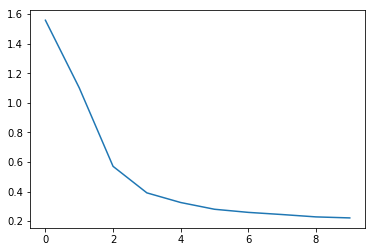

In [400]:
trainIters(encoder, attndecoder, 1000, print_every=500, learning_rate=0.0005)

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

encoder inputs input and hidden =  torch.Size([128, 16]) torch.Size([2, 128, 120])
encoder embedding torch.Size([128, 16, 120])
Encoder output-hidden =  torch.Size([128, 16, 240]) torch.Size([1, 128, 240])
Decoded Input torch.Size([128])
Decoder embedded Input torch.Size([128, 1, 240])
decoder output - hidden torch.Size([128, 1, 240]) torch.Size([1, 128, 240])
meaning of res[:,0] torch.Size([128, 240])
decoder ouput shape torch.Size([128, 28])



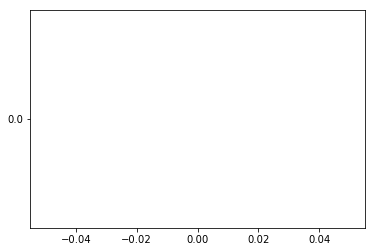

In [34]:
trainIters(encoder, decoder, 1, print_every=500, learning_rate=0.0005)

## Evaluation

In [401]:
def evaluate(encoder, decoder):  
    test_batch = get_batch(input_test, labels_test, batch_size*8)

    input_variable = Variable(torch.LongTensor((test_batch[0].astype('int64'))), volatile=True).cuda()
    target_variable = Variable(torch.LongTensor(test_batch[1].astype('int64')), volatile=True).cuda()

    _, input_length = input_variable.size()
    target_length = target_variable.size()[1]
    encoder_hidden = encoder.initHidden(batch_size*8).cuda()

    encoder_output, encoder_hidden = encoder(input_variable, encoder_hidden)
    decoder_input = Variable(torch.LongTensor([SOS_token]*batch_size*8), volatile=True).cuda()
    #decoder_input = encoder_hidden.squeeze()
    #decoder_input = decoder_input.unsqueeze(1)
    decoder_hidden = encoder_hidden
    decoded_words = []
    for di in range(target_length):
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_output)          
        _, indices = torch.max(decoder_output, 1)
        decoded_words.append(indices)
        decoder_input = indices
    combine = []
    for x in decoded_words:
        combine.append(x.cpu().data.numpy())
    combine = np.array(combine).T
    print ('Accuracy', np.mean([all(real==p) for real, p in zip(test_batch[1], combine)])*100,'%')
    return test_batch, combine

In [402]:
test_batch, preds = evaluate(encoder, attndecoder)

Accuracy 35.44921875 %


In [370]:
input_test=test_batch[0]
labels_test=test_batch[1]
print ('  Phonemes_________________________________predictions____________label')
for index in range(32):
    phoneme = '-'.join([phonemes[p] for p in test_batch[0][index]])
    prediction = [letters[l] for l in preds[index]]
    real = [letters[l] for l in test_batch[1][index]]
    print ('  ',phoneme.strip('-_').ljust(40), ''.join(prediction).strip('_').ljust(20), 
           ''.join(real).strip('_'))

  Phonemes_________________________________predictions____________label
   F-AY1-L-IH0-NG                           filing               filing
   T-AY1-M-AH0                              timea                taima
   G-AO1-L-IH0-NG-ER0                       gallinger            gallinger
   R-EH1-P-R-OW0-G-R-AE2-F                  reprograff           reprograph
   F-AH0-N-AE1-T-AH0-S-IH2-Z-AH0-M          finaticism           fanaticism
   K-AO0-R-N-EH1-T                          cornett              cornet
   G-IH1-S-IH0-N-JH-ER0                     gissinger            guisinger
   M-UW0-S-OW0-L-IY1-N-OW0                  musolino             musolino
   B-R-AO1-CH-ER0                           brotcher             braucher
   B-OY1-T-AH0-L-ER0                        boytaler             beutler
   B-AE1-NG-K                               banke                banque
   HH-IH1-CH-HH-AY2-K-ER0-Z                 hichhickers          hitchhikers
   G-R-EY1-N-JH-IH0-Z                    

In [ ]:
torch.save(encoder, 'models/encoder.dat')
torch.save(decoder, 'models/decoder.dat')

In [ ]:
encoder = torch.load('models/encoder.dat')
decoder = torch.load('models/decoder.dat')